# Convergence testing and parameter recovery

Here we're testing with the SDE model `rev-08a` both convergence $\hat{R}$ values and recovery of simulated parameters.

In [1]:
%pylab inline
import lib.io.stan
import lib.plots.stan
import importlib

Populating the interactive namespace from numpy and matplotlib


## Compile Stan model

In [2]:
%%bash
. /soft/stan/activate
h=`pwd`; cd $CMDSTAN; make CC=g++ $h/vep-fe-rev-08a-fs;

activating stan v2.17.0
make: `/home/duke/src/vep/vep-fe-rev-08a-fs' is up to date.


## Simulate

In this simulation, I'm simply disabling the sampling statement which predicts the data, and allowing the sampler to converge to priors, which runs very quickly.

In [3]:
%%bash
. /soft/stan/activate
cp Rfiles/tvb4-p0-s8-n8.R tmp.R
echo "" >> tmp.R
echo "predict_data <- 0" >> tmp.R
echo "sigma <- 0.000001" >> tmp.R
echo "k <- 0.1" >> tmp.R
./vep-fe-rev-08a-fs sample save_warmup=1 num_warmup=20 num_samples=10 \
    data file=tmp.R output refresh=10 file=tmp.csv

activating stan v2.17.0
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 20
    save_warmup = 1
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = hmc (Default)
      hmc
        engine = nuts (Default)
          nuts
            max_depth = 10 (Default)
        metric = diag_e (Default)
        stepsize = 1 (Default)
        stepsize_jitter = 0 (Default)
id = 0 (Default)
data
  file = tmp.R
init = 2 (Default)
random
  seed = 1539585201
output
  file = tmp.csv
  diagnostic_file =  (Default)
  refresh = 10


Gradient evaluation took 0.02 seconds
1000 transitions using 10 leapfrog steps per transition would take 200 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as curr

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: multiply: B[7] is -nan, but must not be nan!  (in '/home/duke/src/vep/vep-fe-rev-08a-fs.stan' at line 87)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: multiply: B[2] is -nan, but must not be nan!  (in '/home/duke/src/vep/vep-fe-rev-08a-fs.stan' at line 87)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is ab

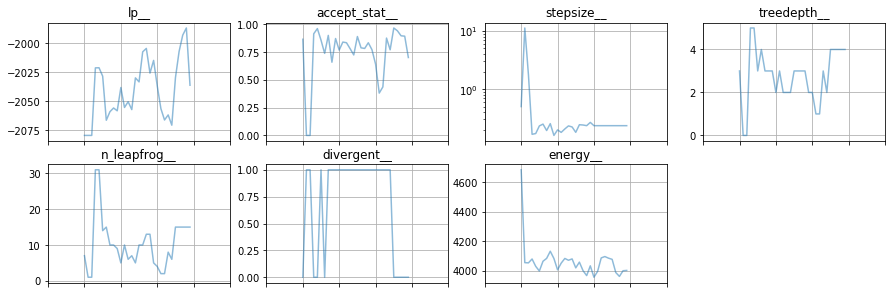

In [10]:
csv = [lib.io.stan.parse_csv('tmp.csv')]
figure(figsize=(15, 10))
lib.plots.stan.trace_nuts(csv)

Example trajectories of $x(t)$ for nodes for a 10 simulations

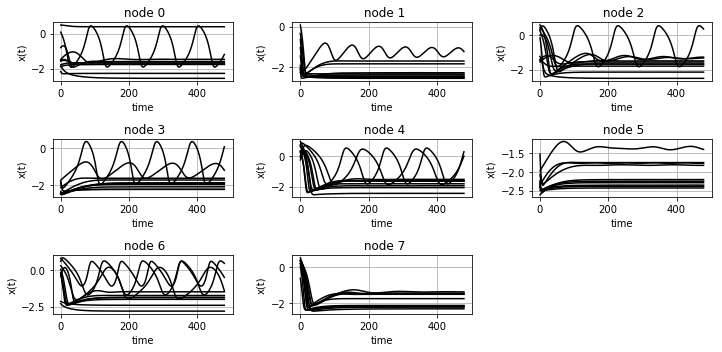

In [11]:
figure(figsize=(10, 5))
for i, xi in enumerate(transpose(csv[0]['x'][-10:], (1, 0, 2))):
    subplot(3, 3, i + 1)
    plot(xi.T[20:], 'k')
    grid(1), ylabel(f'x(t)'), xlabel('time'), title(f' node {i}')
tight_layout()

Let's keep one with the transient for testing,

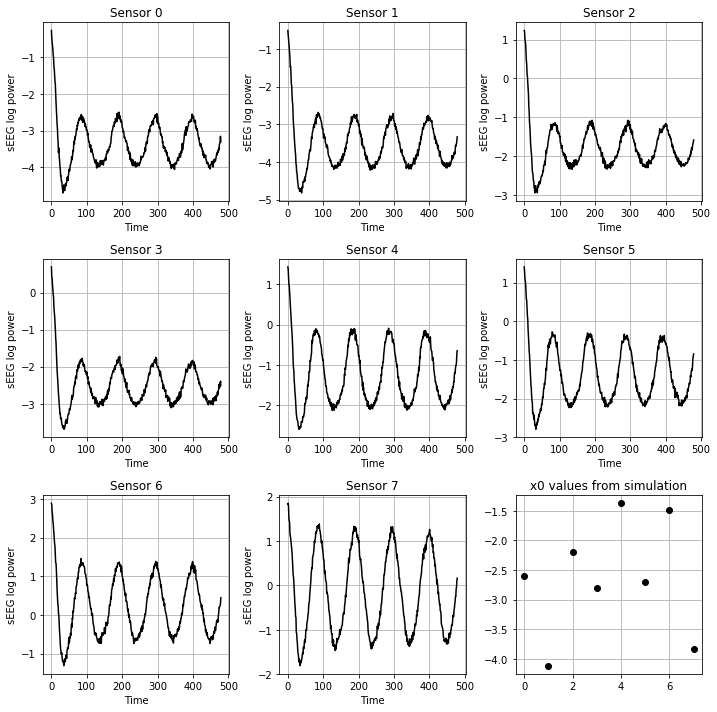

In [12]:
figure(figsize=(10, 10))
for i in range(8):
    subplot(3, 3, i + 1)
    plot(csv[0]['gq_seeg_log_power'][-1, i, 20:].T, 'k')
    grid(1), xlabel('Time'), ylabel('sEEG log power'), title(f'Sensor {i}')
subplot(339), plot(csv[0]['x0'][-6], 'ko'), grid(1), title('x0 values from simulation');
tight_layout()

## Convert simulated data to input

In [13]:
tmp = lib.io.stan.rload('tmp.R')
tmp['seeg_log_power'] = csv[0]['gq_seeg_log_power'][-1].T
tmp['predict_data'] = tmp['nt']
lib.io.stan.rdump('tmp2.R', tmp)

## Fit simulated data

Now we'll fit the simulated data, but here we need several chains, more samples and larger tree depth.  Runs a bit longer than the simulation.

In [21]:
%%bash
. /soft/stan/activate
for i in `seq 8`
do
    ./vep-fe-rev-08a-fs id=$i sample save_warmup=1 num_warmup=200 num_samples=200 \
        algorithm=hmc engine=nuts max_depth=15 \
        data file=tmp2.R output refresh=1 file=tmp2.$i.csv &> tmp2.$i.out &
done

activating stan v2.17.0


In [2]:
!for i in `seq 8`; do echo chain $i `grep Iteration tmp2.$i.out | tail -n 1`; done

chain 1 Iteration: 400 / 400 [100%] (Sampling)
chain 2 Iteration: 400 / 400 [100%] (Sampling)
chain 3 Iteration: 400 / 400 [100%] (Sampling)
chain 4 Iteration: 400 / 400 [100%] (Sampling)
chain 5 Iteration: 400 / 400 [100%] (Sampling)
chain 6 Iteration: 400 / 400 [100%] (Sampling)
chain 7 Iteration: 400 / 400 [100%] (Sampling)
chain 8 Iteration: 389 / 400 [ 97%] (Sampling)


OK, done let's load that

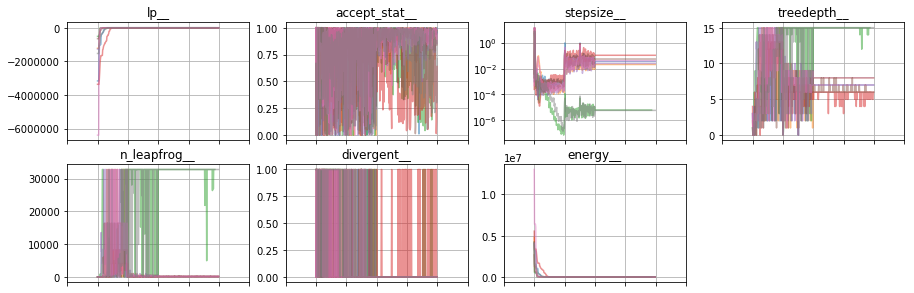

In [8]:
csv2 = lib.io.stan.parse_csv('tmp2.*.csv', merge=False)
figure(figsize=(15, 10))
lib.plots.stan.trace_nuts(csv2)

## Convergence

Let's get the summary especially check $\hat{R}$ values

In [5]:
%%bash
. /soft/stan/activate
rm tmp2-summary.csv  # stansummary appends to the csv file 
stansummary --csv_file=tmp2-summary.csv tmp2.{1,2,3,4,5,6,7}.csv &> tmp2-summary.txt

activating stan v2.17.0


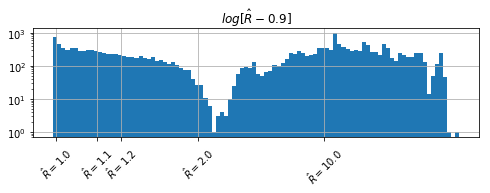

In [20]:
summ_fields, summ_dat = lib.io.stan.parse_summary_csv('tmp2-summary.csv')
figure(figsize=(8,2))
rhats = np.hstack([_[...,-1].reshape((-1, )) for k, _ in summ_dat.items() if '__' not in k])
hist(log(rhats -0.9), 100, log=True), title('$log [\hat{R} - 0.9]$');
rhat_vals = r_[1, 1.1, 1.2, 2, 10]
xticks(log(rhat_vals-0.9), ['$\hat{{R}} = %0.1f$'%(v,) for v in rhat_vals], rotation=45)
grid(1)

Ideally, we want to see $\hat{R}$, the majority of $\hat{R}$ values are > 2, suggesting lack of convergnece. Let's look at effect on parameter recovery: 

## Parameter recovery
It's useful to have chains both merged and unmerged, here `csv2_` is the set of samples merged across all chains

In [17]:
csv2_ = lib.io.stan.merge_csv_data(*csv2, skip=10)

Plot the `x0` posterior

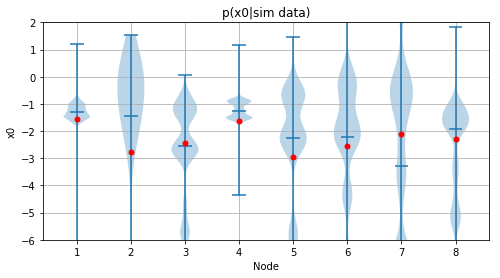

In [14]:
figure(figsize=(8,4))
violinplot(csv2_['x0'][200:], showmedians=True)
plot(np.r_[1:9], csv[0]['x0'][-1], 'ro', markersize=5)
ylim([-6, 2]), grid(1), ylabel('x0'), xlabel('Node'), title('p(x0|sim data)');

Where the red dots are the true values.

We can also see multimodality in the trajectories:

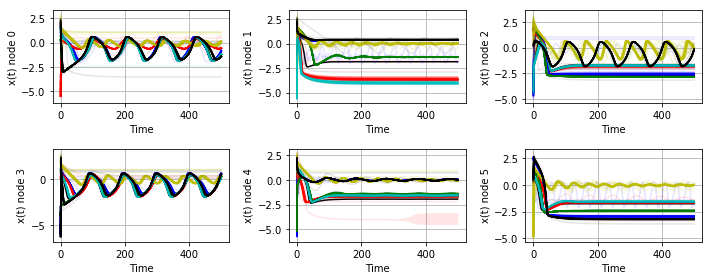

In [16]:
figure(figsize=(10,4))
for i in range(6):
    subplot(2, 3, i + 1)
    plot(csv[0]['x'][-1, i], 'k')
    for j, csv2_j in enumerate(csv2[:6]):
        _ = csv2_j['x'][20::5, i].T
        plot(_, 'brgyckm'[j], alpha=0.1)
    grid(1), ylabel(f'x(t) node {i}'), xlabel('Time')
tight_layout()

Here the trajectories are colored by chain.